In [1]:
#pip install catboost mlflow


In [4]:
import numpy as np
import pandas as pd 
import glob

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.sklearn
import gc

In [6]:
#importation des données de train
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
categorical_features = app_train.select_dtypes(include=['object', 'category']).columns.tolist()
print('List of categorical features:', categorical_features)


List of categorical features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [7]:
# Testing data features
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:

def catboost_model_with_mlflow(features, test_features, cat_features, n_folds=5):
    """Train and test a CatBoost model using cross-validation with MLflow tracking.
    
    Parameters
    ----------
    features (pd.DataFrame): Dataframe of training features with TARGET column.
    test_features (pd.DataFrame): Dataframe of testing features.
    cat_features (list): List of categorical feature names.
    n_folds (int, default=5): Number of folds to use for cross-validation.
    
    Returns
    -------
    submission (pd.DataFrame): Predictions on test data.
    feature_importances (pd.DataFrame): Feature importances from the model.
    metrics (pd.DataFrame): Validation and training AUC metrics for each fold.
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    # Replace NaN values in categorical features with 'missing'
    for cat_feature in cat_features:
        features[cat_feature].fillna('missing', inplace=True)
        test_features[cat_feature].fillna('missing', inplace=True)
    
    # Initialize arrays to store results
    feature_importance_values = np.zeros(len(features.columns))
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for tracking metrics
    valid_scores = []
    train_scores = []

    # Initialize KFold
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)
    
    with mlflow.start_run() as parent_run:
        for fold, (train_indices, valid_indices) in enumerate(k_fold.split(features)):
            print(f"Training fold {fold+1}/{n_folds}...")

            # Split the data
            train_features, train_labels = features.iloc[train_indices], labels.iloc[train_indices]
            valid_features, valid_labels = features.iloc[valid_indices], labels.iloc[valid_indices]
            
            # Create the model
            model = CatBoostClassifier(
                iterations=10000,
                learning_rate=0.05,
                depth=6,
                l2_leaf_reg=0.1,
                loss_function='Logloss',
                eval_metric='AUC',
                random_seed=50,
                cat_features=cat_features,
                logging_level='Silent',
                early_stopping_rounds=100
            )
            
            # Train the model
            model.fit(
                train_features, train_labels,
                eval_set=(valid_features, valid_labels),
                use_best_model=True
            )
            
            # Record the best iteration
            best_iteration = model.best_iteration_

            # Store the out-of-fold predictions
            out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
            
            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_folds
            
            # Predict on test set
            test_predictions += model.predict_proba(test_features)[:, 1] / n_folds
            
            # Record the AUC for validation and training
            valid_auc = roc_auc_score(valid_labels, out_of_fold[valid_indices])
            train_auc = roc_auc_score(train_labels, model.predict_proba(train_features)[:, 1])
            valid_scores.append(valid_auc)
            train_scores.append(train_auc)

            # Start a new nested run for each fold
            with mlflow.start_run(nested=True):
                # Log metrics and parameters to MLflow
                mlflow.log_metric(f"valid_auc_fold_{fold+1}", valid_auc)
                mlflow.log_metric(f"train_auc_fold_{fold+1}", train_auc)
                mlflow.log_param(f"best_iteration_fold_{fold+1}", best_iteration)

        # Log the overall metrics
        overall_valid_auc = roc_auc_score(labels, out_of_fold)
        mean_train_auc = np.mean(train_scores)
        mlflow.log_metric("overall_valid_auc", overall_valid_auc)
        mlflow.log_metric("mean_train_auc", mean_train_auc)
        
        # Log the model
        mlflow.sklearn.log_model(model, "model")

    # Create submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Create feature importance dataframe
    feature_importances = pd.DataFrame({'feature': features.columns, 'importance': feature_importance_values})
    
    # Create metrics dataframe
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    metrics = pd.DataFrame({'fold': fold_names, 'train': train_scores + [mean_train_auc], 'valid': valid_scores + [overall_valid_auc]})
    
    return submission, feature_importances, metrics



In [14]:

submission, fi, metrics = catboost_model_with_mlflow(app_train, app_test, categorical_features, n_folds=2)
print('Baseline metrics')
print(metrics)

Training fold 1/2...
Training fold 2/2...


2024/09/09 16:01:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Baseline metrics
      fold     train     valid
0        0  0.812172  0.757206
1        1  0.798854  0.758244
2  overall  0.805513  0.757700


In [15]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

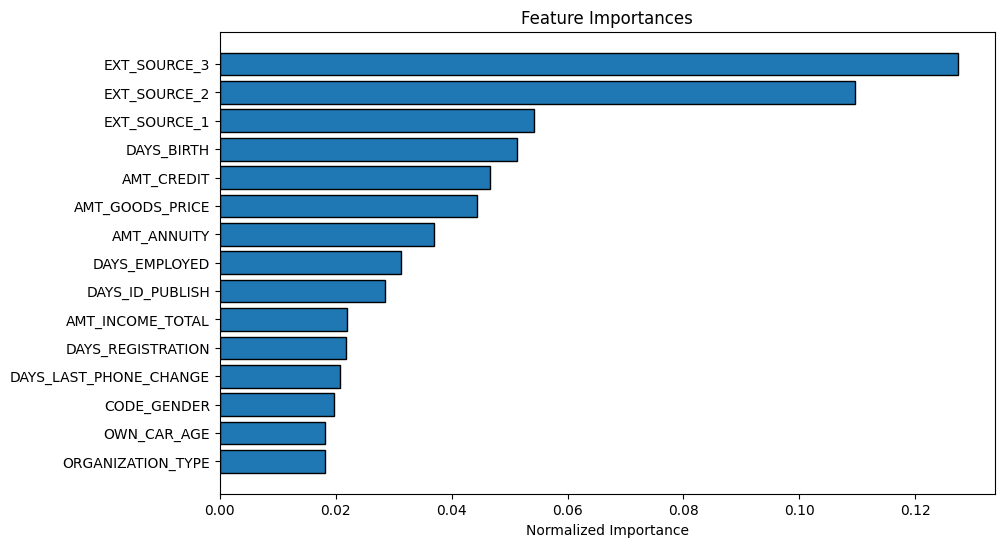

In [16]:
fi_sorted = plot_feature_importances(fi)